# Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset

In [2]:
# Load the 'voc/2007' dataset from TensorFlow Datasets, including metadata information, and specify the 'train+validation' split
dataset, info = tfds.load('voc/2007', with_info=True, split='train+validation')
# Extract the names of the object classes from the dataset's metadata
class_names = info.features['objects']['label'].names
# Print the list of class names to the console
print(f"Classes: {class_names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.ZE94CY_5.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.ZE94CY_5.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.ZE94CY_5.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/5.0.0. Subsequent calls will reuse this data.
Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# General Configuration

In [3]:
class Config:
    IMAGE_SIZE = (224, 244)
    BATCH_SIZE = 32
    NUM_CLASSES = 20
    EPOCHS = 10
    BASE_LR = 0.001

config = Config()

# Preprocess

In [4]:
def preprocess_data(features):
    # Extract the image from the features dictionary
    image = features['image']
    # Resize the image to the predefined IMAGE_SIZE from the Config class
    image = tf.image.resize(image, config.IMAGE_SIZE)
    # Preprocess the image using ResNet50's specific preprocessing function
    image = tf.keras.applications.resnet50.preprocess_input(image)
    # Extract the object labels
    labels = features['objects']['label']
    # Convert labels to a multi-hot encoded vector for multi-label classification
    # tf.one_hot creates one-hot vectors for each label
    # tf.reduce_max with axis=0 combines these into a single multi-hot vector
    multi_hot = tf.reduce_max(tf.one_hot(labels, depth=config.NUM_CLASSES), axis=0)
    return image, multi_hot

# Creating TensorFlow pipeline for efficient data loading and processing
AUTOTUNE = tf.data.AUTOTUNE # Automatically tune the number of parallel calls

# Map the preprocessing function to the dataset elements
dataset = dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
# Shuffle the dataset to ensure randomness in training batches
dataset = dataset.shuffle(1000)
# Batch the dataset into specified BATCH_SIZE
dataset = dataset.batch(config.BATCH_SIZE)
# Prefetch elements to overlap data preprocessing and model execution
dataset = dataset.prefetch(AUTOTUNE)


In [5]:
dataset_size = info.splits['train+validation'].num_examples
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_ds = dataset.take(train_size // config.BATCH_SIZE)
val_ds = dataset.skip(train_size // config.BATCH_SIZE).take(val_size // config.BATCH_SIZE)

print(f"Training dataset size: {tf.data.experimental.cardinality(train_ds).numpy() * config.BATCH_SIZE}")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_ds).numpy() * config.BATCH_SIZE}")


Training dataset size: 4000
Validation dataset size: 992


# Load `ResNet`

In [6]:
# Load the ResNet50 model, pre-trained on ImageNet, without its top classification layer
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Exclude the fully-connected layer at the top of the network
    weights='imagenet', # Load weights pre-trained on ImageNet
    input_shape=(*config.IMAGE_SIZE, 3) # Specify the input shape for the model
)

# Freeze the base model to prevent its weights from being updated during the initial training phase
base_model.trainable = False

# Define a function to add new classification heads on top of the base model
def add_new_heads(base_model):
    # Define the input layer for the new model
    inputs = tf.keras.Input(shape=(*config.IMAGE_SIZE, 3))
    # Pass the inputs through the frozen base model
    x = base_model(inputs, training=False)
    # Apply Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    # Add a dense layer with ReLU activation
    x = layers.Dense(256, activation='relu')(x)
    # Apply dropout for regularization to prevent overfitting
    x = layers.Dropout(0.5)(x)
    # Add the output dense layer with sigmoid activation for multi-label classification
    outputs = layers.Dense(config.NUM_CLASSES, activation='sigmoid',
                           name='multi_label_output')(x)
    # Create the new model combining the inputs and the custom output head
    model = tf.keras.Model(inputs, outputs)
    return model


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
base_resnet = add_new_heads(base_model)
# Compile
base_resnet.compile(optimizer=optimizers.Adam(learning_rate=config.BASE_LR),
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_label_output (Dense)      │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,396 (92.00 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Training
base_model_history = base_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 486ms/step - accuracy: 0.7473 - loss: 0.0327 - val_accuracy: 0.7732 - val_loss: 0.0468
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 474ms/step - accuracy: 0.7660 - loss: 0.0291 - val_accuracy: 0.7097 - val_loss: 0.0398
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 475ms/step - accuracy: 0.7527 - loss: 0.0265 - val_accuracy: 0.7329 - val_loss: 0.0382
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 474ms/step - accuracy: 0.7560 - loss: 0.0242 - val_accuracy: 0.7107 - val_loss: 0.0336
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 469ms/step - accuracy: 0.7452 - loss: 0.0196 - val_accuracy: 0.7107 - val_loss: 0.0333
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 471ms/step - accuracy: 0.7433 - loss: 0.0195 - val_accuracy: 0.6704 - val_loss: 0.0326
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 466ms/step - accuracy: 0.7370 - loss: 0.0184 - val_accuracy: 0.7429 - val_loss: 0.0234
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 467ms/step - accuracy: 0.7526 - loss: 0

# Predictions


Visualizing Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


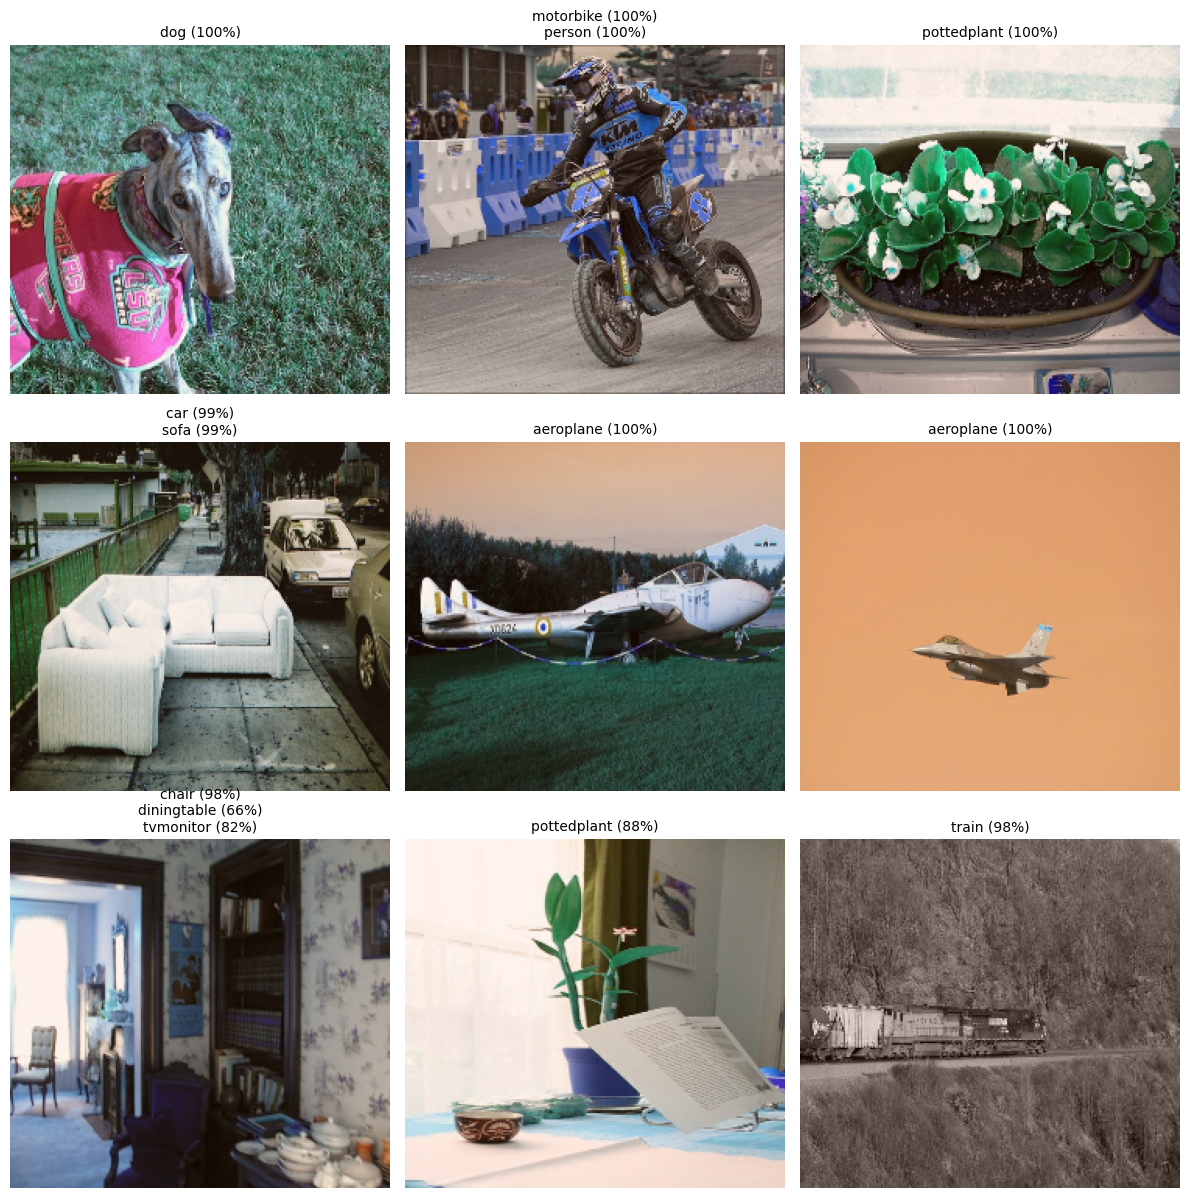

In [15]:
def plot_predictions(dataset, model):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        # Get predictions
        preds = base_resnet.predict(images)

        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            # Display image (reverse ResNet preprocessing for correct color display)
            # ResNet zero-centers the input, we need to reverse it.
            img_show = images[i].numpy()
            img_show = img_show - img_show.min()
            img_show = img_show / img_show.max()
            plt.imshow(img_show)

            # Analyze outputs
            # Here, any number above 0.5 means the model detected that class
            predicted_labels = []
            for idx, probability in enumerate(preds[i]):
                if probability > 0.5: # Decision Threshold
                    label_name = class_names[idx]
                    prob_percent = probability * 100
                    predicted_labels.append(f"{label_name} ({prob_percent:.0f}%)")

            title = "\n".join(predicted_labels)
            if not title: title = "No Object Detected"

            plt.title(title, fontsize=10)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nVisualizing Predictions...")
plot_predictions(val_ds, base_resnet)
